# Abstract

When removing some visual words, for `qid=32, dbid=788` (supports 8, 19) it raises more inliers eventhough it should be a subset. Investigate it!

In [1]:
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from functools import partial
from itertools import cycle
from time import perf_counter
from tabulate import tabulate

from cirtorch.datasets.testdataset import configdataset
from cirtorch.utils.evaluate import compute_map_and_print
from asmk import io_helpers, ASMKMethod, functional, hamming
from examples.demo_how import build_ivf, query_ivf

In [2]:
def get_packed_residuals(vecs, centroids, binary=True):
    residuals = vecs - centroids
    
    if binary:
        return hamming.binarize_and_pack_2D(residuals)
    else:
        return functional.normalize_vec_l2(residuals)
    
def generate_hypotheses(coordx1, coordy1, scales1, coordx2, coordy2, scales2):
    # 1 -> 2
    m = np.tile(np.eye(3), [coordx1.size, 1, 1])
    s = scales2 / scales1
    
    m[:, 0, 2] = -1 * coordx1 * s + coordx2
    m[:, 1, 2] = -1 * coordy1 * s + coordy2
    m[:, 0, 0] = m[:, 1, 1] = s
    
    return m


def compute_errors(hypotheses, coordx1, coordy1, coordx2, coordy2):
    pts1 = np.vstack([coordx1, coordy1, np.ones_like(coordx1)])
    pts2 = np.vstack([coordx2, coordy2, np.ones_like(coordx2)])
    
    # [number of hypotheses, number of correspondences]
    return np.linalg.norm((hypotheses @ pts1) - pts2, axis=1)


def verify_single_model(errors, corrs, inlier_threshold=32):
    n = corrs.shape[0]
    mask = np.zeros([n], dtype=bool)
    taken = set()

    i = 0
    actual_y, best_index = None, None
    best_error = None
    while i < n:
        actual_y = corrs[i, 1]
        
        best_error = np.inf
        best_index = -1
        while i < n and actual_y == corrs[i, 1]:
            if errors[i] < best_error and corrs[i, 0] not in taken:
                best_error = errors[i]
                best_index = i
            i += 1
        
        if best_error <= inlier_threshold:
            mask[best_index] = True
            taken.add(corrs[best_index, 0])
    
    return mask


def verify_models(errors, corrs, inlier_threshold=32):
    return np.apply_along_axis(
        partial(verify_single_model, corrs=corrs, inlier_threshold=inlier_threshold),
        axis=1,
        arr=errors,
    )


def affine_local_optimization(A, coordx1, coordy1, coordx2, coordy2):
    size = coordx1.size
    
    if size < 3:
        return A
    
    weight = 2 * np.pi if size < 11 else 0
    r2h = 50.0  # half of squared circle radius is integrated over
    
    mx1, my1 = coordx1.mean(), coordy1.mean()
    mx2, my2 = coordx2.mean(), coordy2.mean()
    
    dx1, dy1 = (coordx1 - mx1), (coordy1 - my1)
    dx2, dy2 = (coordx2 - mx2), (coordy2 - my2)
    
    # Compute AtA, AtB1, AtB2
    AtA = [0.0, 0.0, 0.0]
    AtB1 = [0.0, 0.0]
    AtB2 = [0.0, 0.0]
    
    AtA[0] = ((1 + weight) * dx1 * dx1 + weight * r2h).sum()
    AtA[1] = ((1 + weight) * dx1 * dy1).sum()
    AtA[2] = ((1 + weight) * dy1 * dy1 + weight * r2h).sum()
    
    AtB1[0] = ((1 + weight) * dx1 * dx2 + weight * A[0, 0] * r2h).sum()
    AtB1[1] = ((1 + weight) * dy1 * dx2 + weight * A[0, 1] * r2h).sum()
    
    AtB2[0] = ((1 + weight) * dx1 * dy2 + weight * A[1, 0] * r2h).sum()
    AtB2[1] = ((1 + weight) * dy1 * dy2 + weight * A[1, 1] * r2h).sum()
    
    # Final affine transformation
    detAtA = AtA[0] * AtA[2] - AtA[1] * AtA[1]
    if detAtA == 0:
        raise ValueError('Determinant equals to zero.')
        
    norm = 1 / detAtA
    H0 = (AtA[2] * AtB1[0] - AtA[1] * AtB1[1]) * norm
    H1 = (-AtA[1] * AtB1[0] + AtA[0] * AtB1[1]) * norm
    H2 = mx2 - mx1 * H0 - my1 * H1
    H3 = (AtA[2] * AtB2[0] - AtA[1] * AtB2[1]) * norm
    H4 = (-AtA[1] * AtB2[0] + AtA[0] * AtB2[1]) * norm
    H5 = my2 - mx1 * H3 - my1 * H4
    
    H = np.array([
        [H0, H1, H2],
        [H3, H4, H5],
        [0, 0, 1],
    ])
    
    return H


def get_tentative_correspondencies(
    q_ids, db_ids, q_residual_packs, db_residual_packs, similarity_func, max_tc=1500, max_MxN=15,
):
    db_unique, db_counts = np.unique(db_ids, return_counts=True)
    q_unique, q_counts = np.unique(q_ids, return_counts=True)
    
    db_sorted = np.argsort(db_ids, kind='stable')
    q_sorted = np.argsort(q_ids, kind='stable')
    
    ret = []
    similarities = []
    # counts = []
    
    qr_i = 0  # query index
    db_i = 0  # database index
    s_qr_i = 0  # sorted query index
    s_db_i = 0  # sorted database index

    qr_len = q_unique.shape[0]
    db_len = db_unique.shape[0]
    s_qry_len = q_sorted.shape[0]
    s_rel_len = db_sorted.shape[0]
    
    while qr_i < qr_len and db_i < db_len:  # While there are any visual words remaining
        if q_unique[qr_i] == db_unique[db_i]:  # If we encountered the the same visual word
            # count = q_counts[qr_i] * db_counts[db_i]
            # if count <= max_MxN:
            if True:
            
                # Move the sorted indexes forward so we find the beginning of current visual word
                while s_qr_i < s_qry_len and q_ids[q_sorted[s_qr_i]] != q_unique[qr_i]:
                    s_qr_i += 1
                while s_db_i < s_rel_len and db_ids[db_sorted[s_db_i]] != db_unique[db_i]:
                    s_db_i += 1
                
                # Cross products of corresponding visual words
                count = q_counts[qr_i] * db_counts[db_i]
                cross_product_correspondences = np.zeros([count, 2])
                cross_product_similarities = np.zeros([count])
                cross_product_index = 0
                
                s_qr_i_start = s_qr_i
                while s_db_i < s_rel_len and db_ids[db_sorted[s_db_i]] == db_unique[db_i]:
                    s_qr_i = s_qr_i_start
                    while s_qr_i < s_qry_len and q_ids[q_sorted[s_qr_i]] == q_unique[qr_i]:
                        #ret.append([q_sorted[s_qr_i], db_sorted[s_db_i]])
                        #similarities.append(similarity_func(
                        #    q_residual_packs[q_sorted[s_qr_i]], db_residual_packs[db_sorted[s_db_i]]
                        #)[0])
                        #vw_ids.append(q_unique[qr_i])
                        
                        cross_product_correspondences[cross_product_index] = [q_sorted[s_qr_i], db_sorted[s_db_i]]
                        cross_product_similarities[cross_product_index] = similarity_func(
                            q_residual_packs[q_sorted[s_qr_i]], db_residual_packs[db_sorted[s_db_i]]
                        )[0]
                        cross_product_index += 1
                        
                        s_qr_i += 1
                    s_db_i += 1
                    
                if count <= max_MxN:
                    mask = np.ones_like(cross_product_similarities, dtype=bool)
                else:
                    threshold = -np.sort(-cross_product_similarities)[max_MxN]
                    mask = cross_product_similarities >= threshold
                    
                ret.extend(cross_product_correspondences[mask][:max_MxN])
                similarities.extend(cross_product_similarities[mask][:max_MxN])
                    
            qr_i += 1
            db_i += 1
        elif q_unique[qr_i] < db_unique[db_i]:
            qr_i += 1
        else:
            db_i += 1
            
    ret_np = np.array(ret, dtype=int, ndmin=2)
        
    # If there are way too many correspondences, crop the result
    similarities_np = np.array(similarities)
    if ret_np.shape[0] > max_tc:
        # counts_np = np.array(counts)
        # keys = np.argsort(counts, kind='stable')[:max_tc]
        # return ret_np[keys]
        
        # If we do not care about the order
        #
        # keys = np.argsort(-similarities_np, kind='stable')[:max_tc]
        # return ret_np[keys], similarities_np[keys]
        
        # If we want to preserve the order (same visual words in a row)
        
        threshold = -np.sort(-similarities_np)[max_tc]
        mask = similarities_np >= threshold
        
        return ret_np[mask][:max_tc], similarities_np[mask][:max_tc]

    return ret_np, similarities_np

In [3]:
scales = np.array([2.0, 1.414, 1.0, 0.707, 0.5, 0.353, 0.25])


def kernel_similarity(v1, v2):
    _, sim = asmk_dataset.kernel.similarity(v1, v2[np.newaxis], np.array([0]), alpha=1, similarity_threshold=-np.inf)
    return sim

In [4]:
PARAMETERS_PATH = 'eccv20_how_r50-_1000'
DATASET = 'roxford5k'
EVAL_FEATURES = 'how_r50-_1000'

# Global variables
package_root = Path('.').resolve().parent / 'asmk'
parameters_path = package_root / "examples" / ("params/%s.yml" % PARAMETERS_PATH)
params = io_helpers.load_params(parameters_path)

globals = {}
globals["root_path"] = (package_root / params['demo_how']['data_folder'])
exp_name = Path(parameters_path).name[:-len(".yml")]
globals["exp_path"] = (package_root / params['demo_how']['exp_folder']) / exp_name

# Setup logging
logger = io_helpers.init_logger(None)
logger.info("All variables and logger set up")

# Run demo
asmk = ASMKMethod.initialize_untrained(params)
logger.info("Created uninitialized ASMK")
asmk = asmk.train_codebook(cache_path=f"{globals['exp_path']}/codebook.pkl")
logger.info("Trained ASMK")

desc = io_helpers.load_pickle(f"{globals['root_path']}/features/{DATASET}_{EVAL_FEATURES}.pkl")
gnd = configdataset(DATASET, f"{globals['root_path']}/test/")

asmk_dataset = build_ivf(asmk, DATASET, desc, globals, logger)

ASMK INFO: All variables and logger set up
ASMK INFO: Created uninitialized ASMK
ASMK INFO: Trained ASMK
ASMK INFO: Loaded indexed ivf


In [5]:
t0 = perf_counter()

# Get centroid ids, then centroids and then residual packs
qvecs_centroid_ids = asmk_dataset.codebook.quantize(desc['qvecs'], multiple_assignment=1)[1].ravel()
# dbvecs_centroid_ids = asmk_dataset.codebook.quantize(desc['vecs'], multiple_assignment=1)[1].ravel()
dbvecs_centroid_ids = np.load('desc_vecs-quantized-dbvecs_centroid_ids.npy')

# ---
q_centroids = asmk_dataset.codebook.centroids[qvecs_centroid_ids]
db_centroids = asmk_dataset.codebook.centroids[dbvecs_centroid_ids]

q_residual_packs = get_packed_residuals(desc['qvecs'], q_centroids, binary=asmk_dataset.kernel.binary)
db_residual_packs = get_packed_residuals(desc['vecs'], db_centroids, binary=asmk_dataset.kernel.binary)

t1 = perf_counter()

(t1 - t0)

6.067265374999806

In [6]:
IMAGES_ROOT = Path('.').resolve().parent / 'oxbuild_images'
MAX_SPATIAL = 100

---

In [7]:
from dataclasses import dataclass
from typing import Any


@dataclass
class DataItem:
    index: int
    vecs: Any
    centroid_ids: Any
    coordx: Any
    coordy: Any
    scales: Any
    residuals: Any
    
    def get(self):
        return (
            self.index,
            self.vecs,
            self.centroid_ids,
            self.coordx,
            self.coordy,
            self.scales,
            self.residuals,
        )
    

class DataIterator:
    def __init__(self, desc, vecs_centroid_ids, residual_packs, prefix='', include_mask=None):
        if include_mask is not None:
            self._imids = desc[f'{prefix}imids'][include_mask]
            self._vecs = desc[f'{prefix}vecs'][include_mask]
            self._coordx = desc[f'{prefix}coordx'][include_mask]
            self._coordy = desc[f'{prefix}coordy'][include_mask]
            self._scales = desc[f'{prefix}scales'][include_mask]
            self._vecs_centroid_ids = vecs_centroid_ids[include_mask]
            self._residual_packs = residual_packs[include_mask]
        else:
            self._imids = desc[f'{prefix}imids']
            self._vecs = desc[f'{prefix}vecs']
            self._coordx = desc[f'{prefix}coordx']
            self._coordy = desc[f'{prefix}coordy']
            self._scales = desc[f'{prefix}scales']
            self._vecs_centroid_ids = vecs_centroid_ids
            self._residual_packs = residual_packs
            
    def get_all_vecs(self):
        return self._vecs
    
    def get_all_imids(self):
        return self._imids
        
    def get_iter(self, idxs):
        if isinstance(idxs, int):
            idxs = range(idxs)
            
        for idx in idxs:
            yield self.get_item(idx)
            
    def get_item(self, idx):
        li = np.searchsorted(self._imids, idx, 'left')
        ri = np.searchsorted(self._imids, idx, 'right')
            
        vecs = self._vecs[li:ri]
        centroid_ids = self._vecs_centroid_ids[li:ri]
        coordx = self._coordx[li:ri]
        coordy = self._coordy[li:ri]
        scales = self._scales[li:ri]
        residuals = self._residual_packs[li:ri]
            
        return DataItem(idx, vecs, centroid_ids, coordx, coordy, scales, residuals)

In [8]:
def pure_sv(qdata, dbdata):
    qi, q_vecs, q_centroid_ids, q_coordx, q_coordy, q_scales, q_residuals = qdata.get()
    dbi, db_vecs, db_centroid_ids, db_coordx, db_coordy, db_scales, db_residuals = dbdata.get()

    # Generate correspondences
    corrs, similarities = get_tentative_correspondencies(
        q_centroid_ids, db_centroid_ids, q_residuals, db_residuals, kernel_similarity
    )
    _similarities = similarities * (similarities > 0)

    assert corrs.size

    # Pick corresponding data
    scales1 = scales[q_scales[corrs[:, 0]]]
    coordx1 = q_coordx[corrs[:, 0]] * 16 / scales1
    coordy1 = q_coordy[corrs[:, 0]] * 16 / scales1
    centroid_ids1 = q_centroid_ids[corrs[:, 0]]

    scales2 = scales[db_scales[corrs[:, 1]]]
    coordx2 = db_coordx[corrs[:, 1]] * 16 / scales2
    coordy2 = db_coordy[corrs[:, 1]] * 16 / scales2
    centroid_ids2 = db_centroid_ids[corrs[:, 1]]

    # Generate hypotheses
    hypotheses = generate_hypotheses(
        coordx1,
        coordy1,
        scales1,
        coordx2,
        coordy2,
        scales2,
    )

    # Compute errors and verify models
    errors = compute_errors(hypotheses, coordx1, coordy1, coordx2, coordy2)
    verifications = verify_models(errors, corrs)

    # Local optimization of the best model
    sorted_hypothesis_indexes = (-(verifications * _similarities[np.newaxis]).sum(axis=1)).argsort()

    total_support = -1
    total_mask = None
    total_A = None
    total_index = None

    for i, best_hypothesis_index in enumerate(sorted_hypothesis_indexes[:10]):
        A = hypotheses[best_hypothesis_index]
        mask = verifications[best_hypothesis_index]

        support = (mask * _similarities).sum()

        while True:
            new_A = affine_local_optimization(A, coordx1[mask], coordy1[mask], coordx2[mask], coordy2[mask])
            errors = compute_errors(new_A[np.newaxis], coordx1, coordy1, coordx2, coordy2)
            new_mask = verify_models(errors, corrs)[0]
            new_support = (new_mask * _similarities).sum()

            if new_support > support:
                support = new_support
                A = new_A
                mask = new_mask
            else:
                break

        if support > total_support:
            total_support = support
            total_A = A
            total_mask = mask
            total_index = best_hypothesis_index
    
    return total_support, total_A, total_mask, centroid_ids2[total_index]

In [9]:
qid = 32
dbid = 788

In [10]:
filepath = 'generated-data/8c-asmk-min-inl.npz'

data = np.load(filepath)
vw_tc = data['vw_tc']
vw_inl = data['vw_inl']
inl_tc_ratio = vw_inl / vw_tc.clip(1)

threshold = 0.1

vw_to_remove = np.flatnonzero(inl_tc_ratio < threshold)
include_mask = ~np.isin(qvecs_centroid_ids, vw_to_remove)

all_query_iterator = DataIterator(desc, qvecs_centroid_ids, q_residual_packs, 'q')
limited_query_iterator = DataIterator(desc, qvecs_centroid_ids, q_residual_packs, 'q', include_mask=include_mask)
db_iterator = DataIterator(desc, dbvecs_centroid_ids, db_residual_packs)

In [11]:
supp, A, mask_all, winner_vw_all = pure_sv(
    qdata=all_query_iterator.get_item(qid),
    dbdata=db_iterator.get_item(dbid),
)
supp, mask_all.sum()

(2.625, 8)

In [12]:
supp, A, mask_limited, winner_vw_limited = pure_sv(
    qdata=limited_query_iterator.get_item(qid),
    dbdata=db_iterator.get_item(dbid),
)
supp, mask_limited.sum()

(3.21875, 19)

---

Lets try to generate all the correspondences and then filter just the correspondences, whether they match in the correct order since the order is crucial.

In [13]:
dbi, db_vecs, db_centroid_ids, db_coordx, db_coordy, db_scales, db_residuals = db_iterator.get_item(dbid).get()

In [14]:
qi, q_vecs, q_centroid_ids, q_coordx, q_coordy, q_scales, q_residuals = limited_query_iterator.get_item(qid).get()
corrs_limited, sim_limited = get_tentative_correspondencies(
    q_centroid_ids, db_centroid_ids, q_residuals, db_residuals, kernel_similarity
)
corrs_vw_limited = q_centroid_ids[corrs_limited[:, 0]]

In [15]:
qi, q_vecs, q_centroid_ids, q_coordx, q_coordy, q_scales, q_residuals = all_query_iterator.get_item(qid).get()
corrs_all, sim_all = get_tentative_correspondencies(
    q_centroid_ids, db_centroid_ids, q_residuals, db_residuals, kernel_similarity
)

# Get visual word for each pair
corrs_vw_all = q_centroid_ids[corrs_all[:, 0]]

# Filter only the subset of visual words
incl_m = ~np.isin(corrs_vw_all, vw_to_remove)  # include_mask
corrs_vw_all = corrs_vw_all[incl_m]

In [16]:
(corrs_vw_all == corrs_vw_limited).all()

True

In [17]:
(sim_all[incl_m] == sim_limited).all()

True

We can see that the correspondences are all right. The mistake must be somewhere else. Let's generate hypotheses.

---

In [18]:
def get_hypotheses(qdata, dbdata, corrs):
    qi, q_vecs, q_centroid_ids, q_coordx, q_coordy, q_scales, q_residuals = qdata.get()
    dbi, db_vecs, db_centroid_ids, db_coordx, db_coordy, db_scales, db_residuals = dbdata.get()
    
    # Pick corresponding data
    scales1 = scales[q_scales[corrs[:, 0]]]
    coordx1 = q_coordx[corrs[:, 0]] * 16 / scales1
    coordy1 = q_coordy[corrs[:, 0]] * 16 / scales1
    centroid_ids1 = q_centroid_ids[corrs[:, 0]]

    scales2 = scales[db_scales[corrs[:, 1]]]
    coordx2 = db_coordx[corrs[:, 1]] * 16 / scales2
    coordy2 = db_coordy[corrs[:, 1]] * 16 / scales2
    centroid_ids2 = db_centroid_ids[corrs[:, 1]]
    
    assert (centroid_ids1 == centroid_ids2).all()

    # Generate hypotheses
    return generate_hypotheses(
        coordx1,
        coordy1,
        scales1,
        coordx2,
        coordy2,
        scales2,
    ), centroid_ids1, scales1

In [19]:
hypotheses_all_limited, cid_all_limited, s1 = get_hypotheses(
    qdata=all_query_iterator.get_item(qid),
    dbdata=db_iterator.get_item(dbid),
    corrs=corrs_all,
)
hypotheses_limited, cid_limited, s2 = get_hypotheses(
    qdata=limited_query_iterator.get_item(qid),
    dbdata=db_iterator.get_item(dbid),
    corrs=corrs_limited,
)

In [20]:
(s1[incl_m] == s2).all()

True

In [21]:
(cid_all_limited[incl_m] == cid_limited).all()

True

In [22]:
(hypotheses_all_limited[incl_m] == hypotheses_limited).all()

True

---

In [23]:
_, _, _l_q_centroid_ids, _, _, _l_q_scales, _ = limited_query_iterator.get_item(qid).get()
_, _, _a_q_centroid_ids, _, _, _a_q_scales, _ = all_query_iterator.get_item(qid).get()

In [24]:
mask = ~np.isin(_a_q_centroid_ids, vw_to_remove)

In [25]:
(_a_q_centroid_ids[mask] == _l_q_centroid_ids).all()

True

centroid ids are all right

In [26]:
(_a_q_scales[mask] == _l_q_scales).all()

True

Scales too. Let's add the correspondences.

In [27]:
corrs_limited.shape, corrs_all.shape

((148, 2), (150, 2))

In [28]:
filtered_all_corresponding_cid = _a_q_centroid_ids[corrs_all[:, 0]]
filtered_all_corresponding_scales = _a_q_scales[corrs_all[:, 0]]

m = ~np.isin(filtered_all_corresponding_cid, vw_to_remove)

filtered_all_corresponding_cid = filtered_all_corresponding_cid[m]
filtered_all_corresponding_scales = filtered_all_corresponding_scales[m]

In [29]:
(filtered_all_corresponding_cid == _l_q_centroid_ids[corrs_limited[:, 0]]).all()

True

In [30]:
(filtered_all_corresponding_scales == _l_q_scales[corrs_limited[:, 0]]).all()

True

---

Just rename some variables

In [31]:
(hypotheses_all_limited[incl_m] == hypotheses_limited).all()

True

In [32]:
hypotheses_all_filtered = hypotheses_all_limited[incl_m]

In [33]:
(hypotheses_all_filtered == hypotheses_limited).all()

True

---

Let's go further. Hypotheses match, go deeper.

First, double check the hypothesis. THen go further.

In [34]:
def pure_sv(qdata, dbdata):
    qi, q_vecs, q_centroid_ids, q_coordx, q_coordy, q_scales, q_residuals = qdata.get()
    dbi, db_vecs, db_centroid_ids, db_coordx, db_coordy, db_scales, db_residuals = dbdata.get()

    # Generate correspondences
    corrs, similarities = get_tentative_correspondencies(
        q_centroid_ids, db_centroid_ids, q_residuals, db_residuals, kernel_similarity
    )
    _similarities = similarities * (similarities > 0)

    assert corrs.size

    # Pick corresponding data
    scales1 = scales[q_scales[corrs[:, 0]]]
    coordx1 = q_coordx[corrs[:, 0]] * 16 / scales1
    coordy1 = q_coordy[corrs[:, 0]] * 16 / scales1
    centroid_ids1 = q_centroid_ids[corrs[:, 0]]

    scales2 = scales[db_scales[corrs[:, 1]]]
    coordx2 = db_coordx[corrs[:, 1]] * 16 / scales2
    coordy2 = db_coordy[corrs[:, 1]] * 16 / scales2
    centroid_ids2 = db_centroid_ids[corrs[:, 1]]

    # Generate hypotheses
    hypotheses = generate_hypotheses(
        coordx1,
        coordy1,
        scales1,
        coordx2,
        coordy2,
        scales2,
    )

    return hypotheses

In [35]:
hypo_all = pure_sv(all_query_iterator.get_item(qid), db_iterator.get_item(dbid))
hypo_limited = pure_sv(limited_query_iterator.get_item(qid), db_iterator.get_item(dbid))

In [36]:
(hypo_all[incl_m] == hypo_limited).all()

True

Futher...

In [37]:
def pure_sv(qdata, dbdata):
    qi, q_vecs, q_centroid_ids, q_coordx, q_coordy, q_scales, q_residuals = qdata.get()
    dbi, db_vecs, db_centroid_ids, db_coordx, db_coordy, db_scales, db_residuals = dbdata.get()

    # Generate correspondences
    corrs, similarities = get_tentative_correspondencies(
        q_centroid_ids, db_centroid_ids, q_residuals, db_residuals, kernel_similarity
    )
    _similarities = similarities * (similarities > 0)

    assert corrs.size

    # Pick corresponding data
    scales1 = scales[q_scales[corrs[:, 0]]]
    coordx1 = q_coordx[corrs[:, 0]] * 16 / scales1
    coordy1 = q_coordy[corrs[:, 0]] * 16 / scales1
    centroid_ids1 = q_centroid_ids[corrs[:, 0]]

    scales2 = scales[db_scales[corrs[:, 1]]]
    coordx2 = db_coordx[corrs[:, 1]] * 16 / scales2
    coordy2 = db_coordy[corrs[:, 1]] * 16 / scales2
    centroid_ids2 = db_centroid_ids[corrs[:, 1]]

    # Generate hypotheses
    hypotheses = generate_hypotheses(
        coordx1,
        coordy1,
        scales1,
        coordx2,
        coordy2,
        scales2,
    )

    # Compute errors and verify models
    errors = compute_errors(hypotheses, coordx1, coordy1, coordx2, coordy2)
    verifications = verify_models(errors, corrs)
    
    return errors, verifications, hypotheses, coordx1, coordy1, coordx2, coordy2

In [38]:
errors_all, verifications_all, *args1 = pure_sv(all_query_iterator.get_item(qid), db_iterator.get_item(dbid))
errors_limited, verifications_limited, *args2 = pure_sv(limited_query_iterator.get_item(qid), db_iterator.get_item(dbid))

In [39]:
errors_all.shape

(150, 150)

In [40]:
(errors_all[:, incl_m][incl_m] == errors_limited).all()

True

In [41]:
verifications_all[:, incl_m][incl_m].shape

(148, 148)

In [42]:
(verifications_all[:, incl_m][incl_m] == verifications_limited).all()

True

Verifications seem to be correct too.

---

In [43]:
def pure_sv(qdata, dbdata):
    qi, q_vecs, q_centroid_ids, q_coordx, q_coordy, q_scales, q_residuals = qdata.get()
    dbi, db_vecs, db_centroid_ids, db_coordx, db_coordy, db_scales, db_residuals = dbdata.get()

    # Generate correspondences
    corrs, similarities = get_tentative_correspondencies(
        q_centroid_ids, db_centroid_ids, q_residuals, db_residuals, kernel_similarity
    )
    _similarities = similarities * (similarities > 0)

    assert corrs.size

    # Pick corresponding data
    scales1 = scales[q_scales[corrs[:, 0]]]
    coordx1 = q_coordx[corrs[:, 0]] * 16 / scales1
    coordy1 = q_coordy[corrs[:, 0]] * 16 / scales1
    centroid_ids1 = q_centroid_ids[corrs[:, 0]]

    scales2 = scales[db_scales[corrs[:, 1]]]
    coordx2 = db_coordx[corrs[:, 1]] * 16 / scales2
    coordy2 = db_coordy[corrs[:, 1]] * 16 / scales2
    centroid_ids2 = db_centroid_ids[corrs[:, 1]]

    # Generate hypotheses
    hypotheses = generate_hypotheses(
        coordx1,
        coordy1,
        scales1,
        coordx2,
        coordy2,
        scales2,
    )

    # Compute errors and verify models
    errors = compute_errors(hypotheses, coordx1, coordy1, coordx2, coordy2)
    verifications = verify_models(errors, corrs)

    # Local optimization of the best model
    return verifications, (-(verifications * _similarities[np.newaxis]).sum(axis=1))#.argsort()


ver_all, res_all = pure_sv(all_query_iterator.get_item(qid), db_iterator.get_item(dbid))
ver_limited, res_limited = pure_sv(limited_query_iterator.get_item(qid), db_iterator.get_item(dbid))

In [44]:
res_all.shape, res_limited.shape

((150,), (148,))

In [45]:
(res_all[incl_m] == res_limited).all()

False

In [46]:
(ver_all[:, incl_m][incl_m] == ver_limited).all()

True

In [47]:
m = (ver_all.sum(axis=1)[incl_m] > ver_limited.sum(axis=1))

In [48]:
ver_limited.sum(axis=1)[m]

array([4, 5, 8])

In [49]:
ver_all.sum(axis=1)[incl_m][m]

array([5, 6, 9])

**Závěr:** Když vyhodíme nějaké TC, pak klesne score některým hzpotézám a ty se již znovu nedostanou do TOP 10, tedy nedostanou se do LO, kde mohou reálně skončit s dobrým výsledkem.

In [50]:
def pure_sv(qdata, dbdata):
    qi, q_vecs, q_centroid_ids, q_coordx, q_coordy, q_scales, q_residuals = qdata.get()
    dbi, db_vecs, db_centroid_ids, db_coordx, db_coordy, db_scales, db_residuals = dbdata.get()

    # Generate correspondences
    corrs, similarities = get_tentative_correspondencies(
        q_centroid_ids, db_centroid_ids, q_residuals, db_residuals, kernel_similarity
    )
    _similarities = similarities * (similarities > 0)

    assert corrs.size

    # Pick corresponding data
    scales1 = scales[q_scales[corrs[:, 0]]]
    coordx1 = q_coordx[corrs[:, 0]] * 16 / scales1
    coordy1 = q_coordy[corrs[:, 0]] * 16 / scales1
    centroid_ids1 = q_centroid_ids[corrs[:, 0]]

    scales2 = scales[db_scales[corrs[:, 1]]]
    coordx2 = db_coordx[corrs[:, 1]] * 16 / scales2
    coordy2 = db_coordy[corrs[:, 1]] * 16 / scales2
    centroid_ids2 = db_centroid_ids[corrs[:, 1]]

    # Generate hypotheses
    hypotheses = generate_hypotheses(
        coordx1,
        coordy1,
        scales1,
        coordx2,
        coordy2,
        scales2,
    )

    # Compute errors and verify models
    errors = compute_errors(hypotheses, coordx1, coordy1, coordx2, coordy2)
    verifications = verify_models(errors, corrs)

    # Local optimization of the best model
    return verifications, _similarities, #(-(verifications * _similarities[np.newaxis]).sum(axis=1))#.argsort()


ver_all, sim_all = pure_sv(all_query_iterator.get_item(qid), db_iterator.get_item(dbid))
ver_limited, sim_limited = pure_sv(limited_query_iterator.get_item(qid), db_iterator.get_item(dbid))

In [51]:
# Check verification
(ver_all[:, incl_m][incl_m] == ver_limited).all()

True

In [52]:
# Rename variable
ver_all_filtered = ver_all[:, incl_m][incl_m]

In [53]:
# Compute scores by hand
score_all = (-(ver_all * sim_all[np.newaxis]).sum(axis=1))
score_limited = (-(ver_limited * sim_limited[np.newaxis]).sum(axis=1))

In [54]:
# Check score for all-filtered
(score_limited == (-(ver_all_filtered * sim_all[incl_m][np.newaxis]).sum(axis=1))).all()

True

In [55]:
m = (score_all[incl_m] != score_limited)
score_limited[m], score_all[incl_m][m]

(array([-0.734375, -1.203125, -2.265625]),
 array([-0.859375, -1.328125, -2.390625]))

In [56]:
score_all[incl_m].min(), score_all[~incl_m]

(-2.390625, array([-1.703125, -0.09375 ]))

In [57]:
idxs_all = score_all.argsort(kind='stable')
idxs_limited = score_limited.argsort(kind='stable')

In [58]:
hypo_all.shape, hypo_limited.shape

((150, 3, 3), (148, 3, 3))

In [59]:
score_all[idxs_all[:10]]

array([-2.390625, -2.21875 , -2.171875, -2.140625, -2.09375 , -2.09375 ,
       -2.09375 , -2.09375 , -2.09375 , -2.09375 ])

In [60]:
score_limited[idxs_limited[:10]]

array([-2.265625, -2.21875 , -2.171875, -2.140625, -2.09375 , -2.09375 ,
       -2.09375 , -2.09375 , -2.09375 , -2.09375 ])

In [61]:
(hypo_all[idxs_all[:10]] == hypo_limited[idxs_limited[:10]]).all()

True

**Závěr 2:** Opět šlo o stable sort...

In [62]:
qid, dbid

(32, 788)

---

In [122]:
def pure_sv(qdata, dbdata):
    qi, q_vecs, q_centroid_ids, q_coordx, q_coordy, q_scales, q_residuals = qdata.get()
    dbi, db_vecs, db_centroid_ids, db_coordx, db_coordy, db_scales, db_residuals = dbdata.get()

    # Generate correspondences
    corrs, similarities = get_tentative_correspondencies(
        q_centroid_ids, db_centroid_ids, q_residuals, db_residuals, kernel_similarity
    )
    _similarities = similarities * (similarities > 0)

    assert corrs.size

    # Pick corresponding data
    scales1 = scales[q_scales[corrs[:, 0]]]
    coordx1 = q_coordx[corrs[:, 0]] * 16 / scales1
    coordy1 = q_coordy[corrs[:, 0]] * 16 / scales1
    centroid_ids1 = q_centroid_ids[corrs[:, 0]]

    scales2 = scales[db_scales[corrs[:, 1]]]
    coordx2 = db_coordx[corrs[:, 1]] * 16 / scales2
    coordy2 = db_coordy[corrs[:, 1]] * 16 / scales2
    centroid_ids2 = db_centroid_ids[corrs[:, 1]]

    # Generate hypotheses
    hypotheses = generate_hypotheses(
        coordx1,
        coordy1,
        scales1,
        coordx2,
        coordy2,
        scales2,
    )

    # Compute errors and verify models
    errors = compute_errors(hypotheses, coordx1, coordy1, coordx2, coordy2)
    verifications = verify_models(errors, corrs)

    # Local optimization of the best model
    sorted_hypothesis_indexes = (-(verifications * _similarities[np.newaxis]).sum(axis=1)).argsort(kind='stable')

    total_support = -1
    total_mask = None
    total_A = None
    total_index = None

    print('idxs', sorted_hypothesis_indexes[:10])
    
    for i, best_hypothesis_index in enumerate(sorted_hypothesis_indexes[:10]):
        A = hypotheses[best_hypothesis_index]
        mask = verifications[best_hypothesis_index]

        support = (mask * _similarities).sum()
        
        print(mask.shape, _similarities.shape, support)
        print('Best hypo:')
        print(A)
        
        return A, mask, support, _similarities

        while True:
            new_A = affine_local_optimization(A, coordx1[mask], coordy1[mask], coordx2[mask], coordy2[mask])
            errors = compute_errors(new_A[np.newaxis], coordx1, coordy1, coordx2, coordy2)
            new_mask = verify_models(errors, corrs)[0]
            new_support = (new_mask * _similarities).sum()

            if new_support > support:
                support = new_support
                A = new_A
                mask = new_mask
            else:
                break

        print(f'#{i} supp={support} inl={mask.sum()}')
                
        if support > total_support:
            total_support = support
            total_A = A
            total_mask = mask
            total_index = best_hypothesis_index
            
        # break
    
    print('bhi', total_index)
    return total_mask.sum()

In [123]:
ts_all = pure_sv(all_query_iterator.get_item(qid), db_iterator.get_item(dbid))
ts_limited = pure_sv(limited_query_iterator.get_item(qid), db_iterator.get_item(dbid))

idxs [ 76 131  73  39  37  41  60  65  74 108]
(150,) (150,) 2.390625
Best hypo:
[[  0.5   0.  208. ]
 [  0.    0.5 260. ]
 [  0.    0.    1. ]]
idxs [ 74 129  71  37  35  39  58  63  72 106]
(148,) (148,) 2.265625
Best hypo:
[[  0.5   0.  208. ]
 [  0.    0.5 260. ]
 [  0.    0.    1. ]]


In [76]:
ts_all, ts_limited

(9, 19)

In [118]:
ts_all[3].shape, ts_limited[3].shape

((150,), (148,))

In [119]:
(ts_all[1][incl_m] == ts_limited[1]).all()

True

In [109]:
ts_all[2], ts_limited[2]

(2.390625, 2.265625)

In [125]:
(ts_all[1][incl_m] * ts_all[3][incl_m]).sum()

2.265625

In [129]:
ts_all[3][~incl_m]

array([0.125  , 0.09375])

Ha!! A tady je vidět to, v čem to asi vězí... V hypotéze spadne mezi inliery i vyřazená korespondence a stáhne model ze správné cesty v LO. Bylo by fajn si to i ověřit obrázkem...

---

In [130]:
IMAGES_ROOT = Path('.').resolve().parent / 'oxbuild_images'

In [133]:
query_img_name = gnd['qimlist'][qid]
result_img_name = gnd['imlist'][dbid]

query_img = plt.imread(IMAGES_ROOT / f'{query_img_name}.jpg')
result_img = plt.imread(IMAGES_ROOT / f'{result_img_name}.jpg')

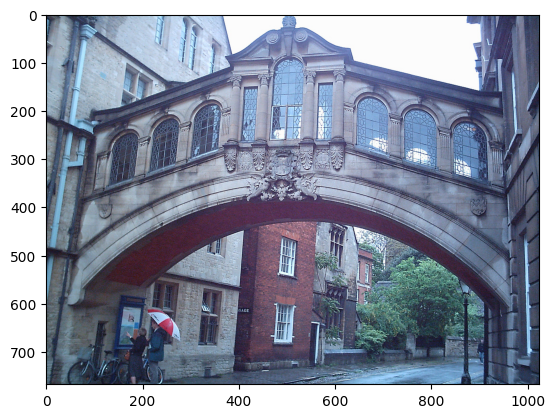

In [134]:
plt.imshow(query_img)
plt.show()

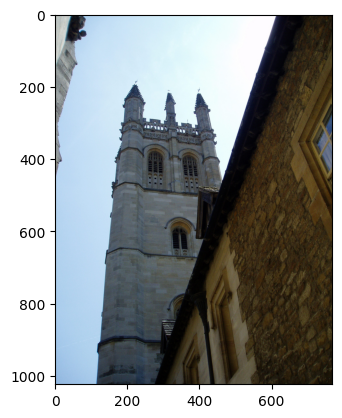

In [135]:
plt.imshow(result_img)
plt.show()